In [1]:
!pip install -q git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/apex-325f5a0/apex-master/
from apex import amp

/opt/conda/lib/python3.7/site-packages/pip/_internal/commands/install.py:235: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Processing /kaggle/input/apex-325f5a0/apex-master
Skipping wheel build for apex, due to binaries being disabled for it.
    Running setup.py install for apex ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done


In [2]:
import os, gc, time, json, copy
import pickle, random, itertools, collections
import tqdm
from functools import partial

import numpy as np
import pandas as pd
from PIL import Image
import cv2

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import pytorch as AT

import segmentation_models_pytorch as smp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Configuration

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 2019

# Data parameters
path = '../input/understanding_cloud_organization'
img_paths = '../input/understanding-clouds-resized'
output_prefix = "best_model_optim.pt"
n_splits = 5
which_fold = 0  # should be int in [0, n_splits-1]

# Learning parameters
batch_size = 32
lr = 1.3e-2
epochs_for_sched = 14
checkpoint_iter = 200
warmup_proportion = 0.25
grad_accumulation_steps = 1

## Utils

In [4]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def seed_torch(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def get_img(x, folder: str='train_images_525/train_images_525'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    """
    Decode run-length encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def make_mask(image_name: str='img.jpg', shape: tuple=(350, 525)):
    "Create mask (ndarray, values between 0-1) based on image name and shape."
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    for classidx, classid in enumerate(["Fish", "Flower", "Gravel", "Sugar"]):
        mask = cv2.imread("../input/understanding-clouds-resized/train_masks_525/train_masks_525/" + classid + image_name)
        if mask is None:
            continue
        if mask[:,:,0].shape != (350,525):
            mask = cv2.resize(mask, (525,350))
        masks[:, :, classidx] = mask[:,:,0]
    masks = masks / 255
    return masks

def mask2rle(img):
    """
    Convert mask to run-length encoding.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot images and masks.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - original ones: If given, show them all
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)        
        
        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mak=None):
    """
    Plot images and masks.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - original ones / raw ones: If given, show them all
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)

    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mak[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)

    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Plot images, masks and augmentation results.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - augment: transformation from albumentations
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    
    Input
    - probability: predicted probability mask, ndarray (350, 525)
    - threshold: value to binarize probability mask
    - min_size: min size to filter false positive
    """
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

def post_process_val(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    
    Input
    - probability: predicted probability mask, ndarray (256, 384)
    - threshold: value to binarize probability mask
    - min_size: min size to filter false positive
    """
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 384), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions


def get_training_augmentation():
    train_transform = [
        albu.Resize(256, 384),
        albu.HorizontalFlip(),
        albu.VerticalFlip(),
        albu.ShiftScaleRotate(scale_limit=0.35, rotate_limit=10, shift_limit=0.1, border_mode=0),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256, 384)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def compute_dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)
    intersection = np.logical_and(img1, img2)
    return 2. * intersection.sum() / (img1.sum() + img2.sum())

## Data overview

Let's have a look at the data first.
We have folders with train and test images, file with train image ids and masks and sample submission.

In [5]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [6]:
n_train = len(os.listdir(f'{img_paths}/train_images_525/train_images_525'))
n_test = len(os.listdir(f'{img_paths}/test_images_525/test_images_525'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


## Preparing data for modelling

At first, let's create a list of unique image_ids and the count of masks for each image. This will allow us to make a stratified split based on this count.

In [7]:
def train_val_split(id_mask_count, n_splits=None, which_fold=None):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in kf.split(id_mask_count['img_id'], id_mask_count['count'])]
    if which_fold is not None:
        return cv_indices[which_fold]
    return cv_indices

In [8]:
id_mask_count = (train.loc[~train['EncodedPixels'].isnull(), 'Image_Label']
                    .apply(lambda x: x.split('_')[0])
                    .value_counts()
                    .reset_index()
                    .rename(columns={'index': 'img_id', 'Image_Label': 'count'}))

trn_idx, val_idx = train_val_split(id_mask_count, n_splits, which_fold)
train_ids, valid_ids = id_mask_count['img_id'].values[trn_idx], id_mask_count['img_id'].values[val_idx]
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [9]:
len(train_ids), len(valid_ids)

(4436, 1110)

In [10]:
id_mask_count

,img_id,count
0,1d20d37.jpg,4
1,0d56b5d.jpg,4
2,1fa5dc9.jpg,4
3,98cfcc2.jpg,4
4,0c1d048.jpg,4
...,...,...
5541,589c00e.jpg,1
5542,3555fe9.jpg,1
5543,da0d544.jpg,1
5544,0d24e80.jpg,1


In [11]:
id_mask_count['count'].value_counts()

2    2372
3    1560
1    1348
4     266
Name: count, dtype: int64

Only 266 images have all four masks.

## Setting up data loader, model, solver

In [12]:
class CloudDataset(Dataset):
    def __init__(self, dataset_type: str='train', img_ids: np.array=None,
                 transforms=albu.Compose([albu.HorizontalFlip(), AT.ToTensor()]),
                 preprocessing=None, label_smooth=0):
        if dataset_type != 'test':
            self.data_folder = f"{img_paths}/train_images_525/train_images_525"
        else:
            self.data_folder = f"{img_paths}/test_images_525/test_images_525"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.label_smooth = label_smooth

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(image_name)
        img = cv2.imread(os.path.join(self.data_folder, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.label_smooth > 0:
            mask = np.where(mask==1, 1-label_smooth, label_smooth).astype('float32')
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In the optimizer initialization, we split model parameters to 3 parts for differential learning rates.

In [13]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = None

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

def model_optimizer_init(ft_lrs, num_labels=4):
    print("Building model and optimizer...")
    model = smp.Unet(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=4, 
        activation=ACTIVATION
    )
    param_g1 = [p for c in list(model.encoder.children())[:5] for p in c.parameters()]
    param_g2 = [p for c in list(model.encoder.children())[5:] for p in c.parameters()]
    optimizer = torch.optim.Adam([
        {'params': param_g1, 'lr': ft_lrs[0]},
        {'params': param_g2, 'lr': ft_lrs[1]}, 
        {'params': model.decoder.parameters(), 'lr': ft_lrs[2]},
    ])
    return model, optimizer

In [14]:
# def dice_loss(input, target):
#     input = torch.sigmoid(input)
#     smooth = 1.0
#     iflat = input.view(-1)
#     tflat = target.view(-1)
#     intersection = (iflat * tflat).sum()
#     return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


# class FocalLoss(nn.Module):
#     def __init__(self, gamma):
#         super().__init__()
#         self.gamma = gamma

#     def forward(self, input, target):
#         if not (target.size() == input.size()):
#             raise ValueError("Target size ({}) must be the same as input size ({})"
#                              .format(target.size(), input.size()))
#         max_val = (-input).clamp(min=0)
#         loss = input - input * target + max_val + \
#             ((-max_val).exp() + (-input - max_val).exp()).log()
#         invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
#         loss = (invprobs * self.gamma).exp() * loss
#         return loss.mean()


# class MixedLoss(nn.Module):
#     def __init__(self, alpha, gamma):
#         super().__init__()
#         self.alpha = alpha
#         self.focal = FocalLoss(gamma)

#     def forward(self, input, target):
#         loss = self.alpha * self.focal(input, target) - torch.log(dice_loss(input, target))
#         return loss.mean()

In [15]:
# Functions for the training process

class NetSolver(object):

    def __init__(self, model, criterion, optimizer, scheduler, print_freq, filepath):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.print_freq = print_freq
        self.filepath = filepath

        self.model = self.model.to(device)
        self.criterion = self.criterion.to(device)
        self._reset()

    def _reset(self):
        """Set up some book-keeping variables for optimization.
        """
        self.best_val_loss = 1e4
        self.best_val_dice = 0.
        self.loss_history = []
        self.val_loss_history = []
        self.dice_history = []
        self.val_dice_history = []
        self.models = {}

    def save_checkpoint(self, iteration):
        """Save model checkpoint.
        """
#         self.models[f'ckpt_{iteration}'] = self.model.state_dict()
        self.model_state = self.model.state_dict()
    
    def save_final_state(self):
        """Save final states.
        """
        state = {'model': self.model_state,
                 'optimizer': self.optimizer.state_dict()
                 }
        torch.save(state, self.filepath)

    def forward_pass(self, im, gt):
        """Forward pass through the network.
        """
        im, gt = im.to(device=device, dtype=torch.float), gt.to(device=device, dtype=torch.float)
        scores = self.model(im)
        loss = self.criterion(scores, gt)
        return loss, torch.sigmoid(scores)

    def train(self, loaders, iterations, start_time):
        """Weight of network updated by apex, grad accumulation, model checkpoint.
        """
        train_loader, val_loader = loaders
        loader = iter(train_loader)
        running_loss = 0.
        self.optimizer.zero_grad()

        # start training for iterations
        for i in range(iterations):
            self.model.train()

            try:
                im, gt = next(loader)
            except:
                loader = iter(train_loader)
                im, gt = next(loader)
            loss, _ = self.forward_pass(im, gt)
            
#             loss.backward()
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()

            # gradient accumulation for larger batch size effect with smaller memory usage
            if (i+1) % grad_accumulation_steps == 0:   # Wait for several backward steps
                self.optimizer.step()                  # Now we can do an optimizer step
                self.optimizer.zero_grad()
                self.scheduler.step()

            running_loss += loss.item()
            
            # verbose and checkpoint
            if (i+1) % self.print_freq == 0 or (i+1) == iterations:
                print(f'Iteration {i+1}:')
                train_dice, train_rdice, _ = self.check_metric(train_loader, num_batches=50)
                print('{"metric": "Loss", "value": %.4f}' % (running_loss/(i+1),))
                print('{"metric": "DICE", "value": %.4f}' % (train_dice,))
                print('{"metric": "RDICE", "value": %.4f}' % (train_rdice,))
                
                is_print = False if (i+1) < iterations else True
                val_dice, val_rdice, val_loss = self.check_metric(val_loader)
                print('{"metric": "Val. Loss", "value": %.4f}' % (val_loss,))
                print('{"metric": "Val. DICE", "value": %.4f}' % (val_dice,))
                print('{"metric": "Val. RDICE", "value": %.4f}' % (val_rdice,))
                
                self.loss_history.append(running_loss/(i+1))
                self.val_loss_history.append(val_loss)
                self.dice_history.append(train_dice)
                self.val_dice_history.append(val_dice)
                
                if val_loss < self.best_val_loss:
                    print('updating best val loss...')
                    self.best_val_loss = val_loss
                    self.save_checkpoint(i+1)
                if val_dice > self.best_val_dice:
                    print('updating best val auc...')
                    self.best_val_dice = val_dice
                
                torch.cuda.empty_cache()
                print()
                
            if (time.time() - start_time) > 29000:
                break
        
        self.save_final_state()

    def check_metric(self, loader, num_batches=None):
        """Calculate metrics for validation
        """
        self.model.eval()
        losses, dices, rdices = [], [], []
        with torch.no_grad():
            for t, (im, gt) in enumerate(loader):
                l, probs = self.forward_pass(im, gt)
                losses.append(l.item())
                dices.append(compute_dice((probs.cpu().numpy()>=0.5),
                                          gt.cpu().numpy()))
                rdices.append(compute_dice(post_process_val(probs.cpu().numpy(), 0.5, 5000),
                                           gt.cpu().numpy()))
                if num_batches is not None and (t+1) == num_batches:
                    break

        loss = np.mean(losses)
        dice = np.mean(dices)
        rdice = np.mean(rdices)

        return dice, rdice, loss

In [16]:
class OneCycleScheduler(object):
    # one-cycle scheduler
    SCHEDULES = set(['cosine', 'linear', 'linear_cosine'])

    def __init__(self, optimizer, iterations, sched_profile='cosine', max_lr=3e-3,
                 moms=(.95, .85), div_factor=25, warmup=0.3, final_div=None):

        self.optimizer = optimizer
        assert sched_profile in self.SCHEDULES
        self.sched_profile = sched_profile

        if isinstance(max_lr, list) or isinstance(max_lr, tuple):
            if len(max_lr) != len(optimizer.param_groups):
                raise ValueError("expected {} max_lr, got {}".format(
                    len(optimizer.param_groups), len(max_lr)))
            self.max_lrs = list(max_lr)
            self.init_lrs = [lr/div_factor for lr in self.max_lrs]
        else:
            self.max_lrs = [max_lr] * len(optimizer.param_groups)
            self.init_lrs = [max_lr/div_factor] * len(optimizer.param_groups)

        self.final_div = final_div
        if self.final_div is None: self.final_div = div_factor*1e4
        self.final_lrs = [lr/self.final_div for lr in self.max_lrs]
        self.moms = moms

        self.total_iteration = iterations
        self.up_iteration = int(self.total_iteration * warmup)
        self.down_iteration = self.total_iteration - self.up_iteration

        self.curr_iter = 0
        self._assign_lr_mom(self.init_lrs, [moms[0]]*len(optimizer.param_groups))

    def _assign_lr_mom(self, lrs, moms):
        for param_group, lr, mom in zip(self.optimizer.param_groups, lrs, moms):
            param_group['lr'] = lr
            param_group['betas'] = (mom, 0.999)

    def _annealing_cos(self, start, end, pct):
        cos_out = np.cos(np.pi * pct) + 1
        return end + (start-end)/2 * cos_out

    def _annealing_linear(self, start, end, pct):
        return start + pct * (end-start)
    
    def _annealing_function(self, curr_iter):
        if self.sched_profile == 'cosine':
            return self._annealing_cos
        if self.sched_profile == 'linear':
            return self._annealing_linear
        if self.sched_profile == 'linear_cosine':
            if curr_iter <= self.up_iteration:
                return self._annealing_linear
            else:
                return self._annealing_cos
    
    def step(self):
        self.curr_iter += 1
        anneal = self._annealing_function(self.curr_iter)

        if self.curr_iter <= self.up_iteration:
            pct = self.curr_iter / self.up_iteration
            curr_lrs = [anneal(min_lr, max_lr, pct) \
                            for min_lr, max_lr in zip(self.init_lrs, self.max_lrs)]
            curr_moms = [anneal(self.moms[0], self.moms[1], pct) \
                            for _ in range(len(self.optimizer.param_groups))]
        else:
            pct = (self.curr_iter-self.up_iteration) / self.down_iteration
            curr_lrs = [anneal(max_lr, final_lr, pct) \
                            for max_lr, final_lr in zip(self.max_lrs, self.final_lrs)]
            curr_moms = [anneal(self.moms[1], self.moms[0], pct) \
                            for _ in range(len(self.optimizer.param_groups))]

        self._assign_lr_mom(curr_lrs, curr_moms)

def lr_range_test(train_loader, model, optimizer, criterion, start_lr=1e-7,
                  end_lr=10, num_it=100, stop_div=True):
    epochs = int(np.ceil(num_it/len(train_loader)))
    n_groups = len(optimizer.param_groups)

    if isinstance(start_lr, list) or isinstance(start_lr, tuple):
        if len(start_lr) != n_groups:
            raise ValueError("expected {} max_lr, got {}".format(n_groups, len(start_lr)))
        start_lrs = list(start_lr)
    else:
        start_lrs = [start_lr] * n_groups

    if isinstance(end_lr, list) or isinstance(end_lr, tuple):
        if len(end_lr) != n_groups:
            raise ValueError("expected {} max_lr, got {}".format(n_groups, len(end_lr)))
        end_lrs = list(end_lr)
    else:
        end_lrs = [end_lr] * n_groups

    curr_lrs = start_lrs*1
    for param_group, lr in zip(optimizer.param_groups, curr_lrs):
        param_group['lr'] = lr

    n, lrs_logs, loss_log = 0, [], []

    for e in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device=device, dtype=torch.float), y.to(device=device, dtype=torch.float)
            scores = model(x)
            loss = criterion(scores, y)

            optimizer.zero_grad()
#             loss.backward()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()

            lrs_logs.append(curr_lrs)
            loss_log.append(loss.item())

            # update best loss
            if n == 0:
                best_loss, n_best = loss.item(), n
            else:
                if loss.item() < best_loss:
                    best_loss, n_best = loss.item(), n

            # update lr per iter with exponential schedule
            n += 1
            curr_lrs = [lr * (end_lr/lr) ** (n/num_it) for lr, end_lr in zip(start_lrs, end_lrs)]
            for param_group, lr in zip(optimizer.param_groups, curr_lrs):
                param_group['lr'] = lr

            # stopping condition
            if n == num_it or (stop_div and (loss.item() > 4*best_loss or torch.isnan(loss))):
                break

    print('minimum loss {}, at lr {}'.format(best_loss, lrs_logs[n_best]))
    return lrs_logs, loss_log

## Model training

In [17]:
train_dataset = CloudDataset(dataset_type='train', img_ids=train_ids,
                             transforms=get_training_augmentation(),
                             preprocessing=get_preprocessing(preprocessing_fn))

valid_dataset = CloudDataset(dataset_type='valid', img_ids=valid_ids,
                             transforms=get_validation_augmentation(),
                             preprocessing=get_preprocessing(preprocessing_fn))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=4, pin_memory=True)

In [18]:
# model setup
seed_torch(SEED)
torch.cuda.empty_cache()

num_train_steps = int(epochs_for_sched * len(train_loader) / grad_accumulation_steps)
ft_lrs = [0.0025*lr, 0.05*lr, lr]

model, optimizer = model_optimizer_init(ft_lrs)
scheduler = OneCycleScheduler(optimizer, num_train_steps, sched_profile='cosine', max_lr=ft_lrs,
                              warmup=warmup_proportion)

model = model.to(device)
criterion = smp.utils.losses.DiceLoss(eps=1., activation='sigmoid').to(device)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)
solver = NetSolver(model, criterion, optimizer, scheduler, checkpoint_iter, output_prefix)

print()
print('Each allocated and cached memory in cuda (will clean cache):')
print(str(torch.cuda.memory_allocated(device)/1e6 ) + 'M')
print(str(torch.cuda.memory_cached(device)/1e6 ) + 'M')
torch.cuda.empty_cache()

Building model and optimizer...


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth




Each allocated and cached memory in cuda (will clean cache):
131.667968M
155.189248M


/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


In [19]:
n_iter = num_train_steps * grad_accumulation_steps
print('Start training.')
t0 = time.time()
solver.train((train_loader, valid_loader), n_iter, t0)
print('Training complete in {:.0f} seconds.'.format(time.time()-t0))

print()
print('Each allocated and cached memory in cuda (will clean cache):')
print(str(torch.cuda.memory_allocated(device)/1e6 ) + 'M')
print(str(torch.cuda.memory_cached(device)/1e6 ) + 'M')
torch.cuda.empty_cache()

Start training.
Iteration 200:
{"metric": "Loss", "value": 0.6280}
{"metric": "DICE", "value": 0.5139}
{"metric": "RDICE", "value": 0.0000}
{"metric": "Val. Loss", "value": 0.5765}
{"metric": "Val. DICE", "value": 0.5069}
{"metric": "Val. RDICE", "value": 0.0000}
updating best val loss...
updating best val auc...

Iteration 400:
{"metric": "Loss", "value": 0.5819}
{"metric": "DICE", "value": 0.4879}
{"metric": "RDICE", "value": 0.0000}
{"metric": "Val. Loss", "value": 0.5280}
{"metric": "Val. DICE", "value": 0.4941}
{"metric": "Val. RDICE", "value": 0.0000}
updating best val loss...

Iteration 600:
{"metric": "Loss", "value": 0.5436}
{"metric": "DICE", "value": 0.5494}
{"metric": "RDICE", "value": 0.0000}
{"metric": "Val. Loss", "value": 0.4547}
{"metric": "Val. DICE", "value": 0.5560}
{"metric": "Val. RDICE", "value": 0.0000}
updating best val loss...
updating best val auc...

Iteration 800:
{"metric": "Loss", "value": 0.5174}
{"metric": "DICE", "value": 0.5790}
{"metric": "RDICE", "v

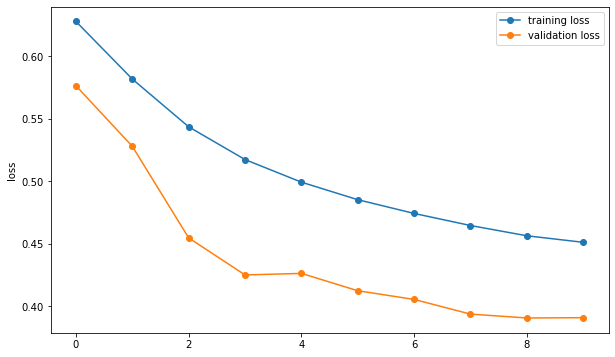

In [20]:
plt.figure(figsize=(10,6))
plt.plot(solver.loss_history, marker='o', label="training loss")
plt.plot(solver.val_loss_history, marker='o', label="validation loss")
plt.ylabel('loss')
plt.legend()
plt.show()

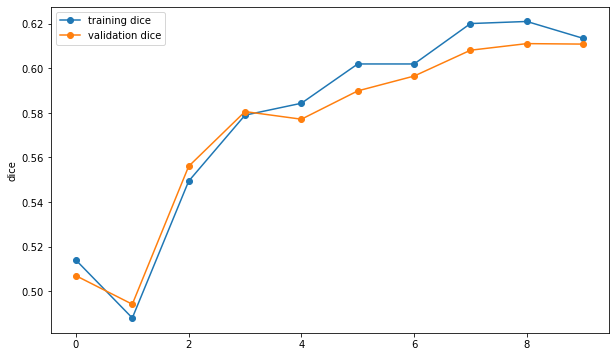

In [21]:
plt.figure(figsize=(10,6))
plt.plot(solver.dice_history, marker='o', label="training dice")
plt.plot(solver.val_dice_history, marker='o', label="validation dice")
plt.ylabel('dice')
plt.legend()
plt.show()